# Setup

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint as pp
import pickle
%matplotlib inline
import seaborn as sns
np.random.seed(20)

In [7]:
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [10]:
NB_DIR = Path.cwd()

In [11]:
#Insert relevant directories here
LOCAL_DATA = 
RAW_DATA = 
DF_ROI = 
PY_DIR = 
MODELS = 

In [16]:
pd.set_option("display.max_columns", 200)

In [17]:
# Loading data
test_lin_feat = pd.read_pickle(DF_ROI/'TEST_Table_of_Features_Vent_Hipp_Linear_sMCI_cAD.pkl')
train_lin_feat = pd.read_pickle(DF_ROI/'TRAIN_Table_of_Features_Vent_Hipp_Linear_sMCI_cAD.pkl')

test_Nlin_feat = pd.read_pickle(DF_ROI/'TEST_Table_of_Features_Vent_Hipp_NonLinear_sMCI_cAD.pkl')
train_Nlin_feat = pd.read_pickle(DF_ROI/'TRAIN_Table_of_Features_Vent_Hipp_NonLinear_sMCI_cAD.pkl')

# Functions

In [19]:
def change_column_names(dictionary, covar, rm_col , dx, age_max = True, age_mean = True):
    '''
    This function changes the name of columns 
    dictionary is a dictionary of data frame of all the regions
    covar is the roi that we want to change the name of features (columns) name
    rm_col is a list of columns that we need to remove from features because there are the same for all the covars
    '''

    suffix = '_' + covar[:4]
    covar_df1 = dictionary[covar]
    if 'RID' in covar_df1.columns:
        covar_df1 = covar_df1.set_index('RID')
    covar_df1=covar_df1.rename(columns = {'Age_at_scan':'random_slope', 'max_change':'slop'})
    y = covar_df1[dx]
    cols = [c for c in covar_df1.columns if c not in rm_col] 
    covar_df = covar_df1[cols]
    covar_df=covar_df.add_suffix(suffix)
    covar_df['SEX'] = covar_df1['SEX']
    if age_max: covar_df['Current_Age'] = covar_df1['Max_AGE']
    if age_mean:covar_df['AGE_mean'] = covar_df1['AGE_mean']
    return covar_df ,y , suffix
    

In [21]:
def combine_ROIs(dic1,dic2, roi1,roi2, rm_cols, dx):
    '''
    This function combines the features of more than one ROIs
    '''
    X1,y1,sx1 = change_column_names(dic1, roi1, rm_cols, dx)
    X2,y2 ,sx2= change_column_names(dic2,roi2, rm_cols, dx)
    X1 = X1.sort_index()
    X2 = X2.sort_index()
    print(f'\n Same order for features is {X1.SEX.equals(X2.SEX)}')
    print(X1.shape, X2.shape)
    y1 = y1.sort_index()
    y2 = y2.sort_index()
    print(f'Same order for labels is {y1.equals(y2)}')

    X = pd.concat([X1,X2], axis=1)
    X =X.loc[:,~X.columns.duplicated()]
    y = y1
    return X,y

In [22]:
def save_model(model, fn):
    with open(MODELS/fn, 'wb') as file:
        pickle.dump(model, file)

In [34]:
def evaluate_model(model, data, labels, nb_splits ,return_results=False, verbose=False):
    """
    Leave-one-out cross-validation using the given model
    Outputs resulting confusion matrix
    """
    
    crossval = cross_validate(model, X=data, y=labels, cv=nb_splits, return_estimator=True, return_train_score=True, n_jobs=-1)
    estimator = crossval['estimator']
    fit_time = crossval['fit_time']
    score_time = crossval['score_time']
    train_score = crossval['train_score']
    test_score = crossval['test_score']
    
    print(f"Mean test accuracy: {test_score.mean()}")
    print(f"Mean train accuracy: {train_score.mean()}")
    
    if verbose:
        print("#"*40)
        print(f"Total fit time: {np.round(fit_time.sum(),2)} sec")
        print(f"Total evaluate time: {np.round(fit_time.sum() + score_time.sum(),2)} sec")
        
    if return_results: 
        return crossval

In [41]:
def run_gridsearch(model, param_grid, data , y ,cv, reevaluate=True):
        
    # Set up grid search
    gs_reg = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)
    print(data.shape, y.shape)
    gs_reg.fit(data, y)
    
    # Results
    print(f"Best accuracy: {gs_reg.best_score_}")
    estimator = gs_reg.best_estimator_
    if reevaluate:
        print("Re-evaluating using `evaluate_model` and leave-one-out")
        evaluate_model(estimator, data,y, cv)

    return estimator

In [25]:
def evaluate_ensemble(models,X,y,nb_splits, voting='soft'):
    '''
    This function calculate the ensemble model by voting strategy.
    models is a list of models to build ensemble model
    '''
    estimators = list(zip((['mod'+str(i) for i in range(len(models))]), models))
    eclf = VotingClassifier(
                            estimators=estimators,
                            voting=voting,
                            n_jobs=-1)
    evaluate_model(eclf, X,y,nb_splits )
    return eclf

In [27]:
def confusion_matrix_permutation(model, X_train,X_test,y_train,y_test, title ,label = 'DX2'):
    
    print(f"training score :  {np.round(model.score(X_test, y_test),3)}")
    clf_score= model.score(X_test, y_test).round(2)
    cm = confusion_matrix(y_test, model.predict(X_test))
    
     
    y_pred=model.predict(X_test)
    test_detail = pd.DataFrame(y_test)
    test_detail['pred'] = y_pred
    mis_pred = []
    for rid in test_detail.index:
        if test_detail.loc[rid,label] != test_detail.loc[rid,'pred'] :
            mis_pred.append(rid)
    #------------------------
   
    classes = np.unique(y_test)
    print(list(zip(*np.unique(y_test,return_counts=True))))
    fig, ax = plt.subplots(figsize =(10,10))
    sns.set(font_scale=2.5, style='dark')
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        
        xticklabels=classes,
        yticklabels=classes,
        title= title, #'Confusion Matrix',
        ylabel='True label',
        xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

    print(classification_report(y_test, model.predict(X_test)))
    
    print('Permutation Importance based on Testset\n')
    perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
    display(eli5.show_weights(perm, feature_names = X_test.columns.tolist()))
    imp_feat = eli5.explain_weights_df(perm,feature_names = X_test.columns.tolist())
    
    return np.array(mis_pred), test_detail, imp_feat

# Final Test

## Linear

In [321]:
dic_r = {'sMCI': 'sMCI', 'cAD': 'rMCI'}

DX2            1.000000
Age_at_scan    0.271739
max_change     0.247135
dev_last       0.182594
dev_bl         0.138779
SEX            0.021708
AGE_mean      -0.124712
Max_AGE       -0.193917
Group         -0.251998
Name: DX2, dtype: float64


,Group,Age_at_scan,dev_bl,dev_last,max_change,AGE_mean,Max_AGE,SEX,DX2
Group,1.00,-0.98,-0.14,-0.31,-0.52,-0.08,-0.05,-0.00,-0.25
Age_at_scan,-0.98,1.00,0.30,0.45,0.54,-0.02,-0.05,0.02,0.27
dev_bl,-0.14,0.30,1.00,0.98,0.37,-0.59,-0.59,0.09,0.14
dev_last,-0.31,0.45,0.98,1.00,0.45,-0.54,-0.55,0.09,0.18
max_change,-0.52,0.54,0.37,0.45,1.00,-0.03,-0.06,0.04,0.25
AGE_mean,-0.08,-0.02,-0.59,-0.54,-0.03,1.00,0.99,0.10,-0.12
Max_AGE,-0.05,-0.05,-0.59,-0.55,-0.06,0.99,1.00,0.10,-0.19
SEX,-0.00,0.02,0.09,0.09,0.04,0.10,0.10,1.00,0.02
DX2,-0.25,0.27,0.14,0.18,0.25,-0.12,-0.19,0.02,1.00


number of split 210

 ================== Logistic Regession =====================

Standard scaler 

(431, 8) (431,)
Fitting 210 folds for each of 20 candidates, totalling 4200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 4110 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:   11.1s finished


Best accuracy: 0.7968253968253968
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7968253968253968
Mean train accuracy: 0.7993650949258425
Logistic Regression score: 0.7355371900826446
training score :  0.736
[('rMCI', 60), ('sMCI', 61)]


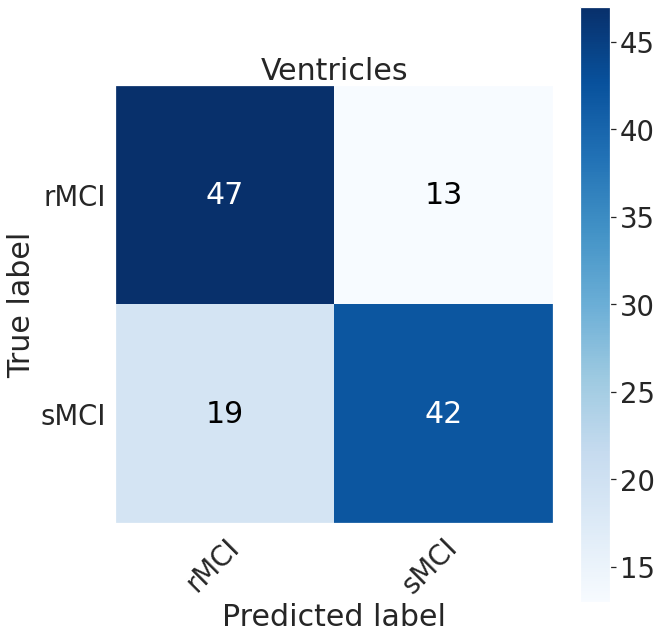

              precision    recall  f1-score   support

        rMCI       0.71      0.78      0.75        60
        sMCI       0.76      0.69      0.72        61

    accuracy                           0.74       121
   macro avg       0.74      0.74      0.74       121
weighted avg       0.74      0.74      0.73       121

Permutation Importance based on Testset



Weight,Feature
0.2397 ± 0.0717,Max_AGE
0.1901 ± 0.0314,AGE_mean
0.1504 ± 0.0664,Age_at_scan
0.1322 ± 0.0717,dev_last
0.0876 ± 0.0939,dev_bl
0.0198 ± 0.0247,Group
0.0132 ± 0.0224,SEX
0.0116 ± 0.0340,max_change



 ================== SVM =====================

(431, 8) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.1min finished


Best accuracy: 0.7103174603174602
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7103174603174602
Mean train accuracy: 0.7894737142400694
(431, 8) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 9392 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 11768 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.3min finished


Best accuracy: 0.7730158730158729
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7730158730158729
Mean train accuracy: 0.8094232351241697
SVM score: 0.6776859504132231
training score :  0.678
[('rMCI', 60), ('sMCI', 61)]


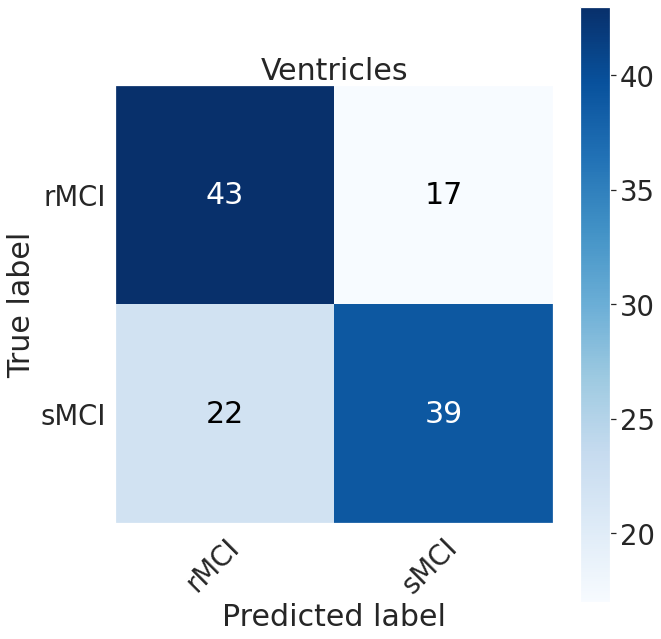

              precision    recall  f1-score   support

        rMCI       0.66      0.72      0.69        60
        sMCI       0.70      0.64      0.67        61

    accuracy                           0.68       121
   macro avg       0.68      0.68      0.68       121
weighted avg       0.68      0.68      0.68       121

Permutation Importance based on Testset



Weight,Feature
0.1455 ± 0.0690,Max_AGE
0.1124 ± 0.0324,AGE_mean
0.0826 ± 0.0418,Age_at_scan
0.0727 ± 0.0472,Group
0.0331 ± 0.0501,dev_bl
0.0182 ± 0.0264,dev_last
0.0033 ± 0.0399,SEX
-0.0132 ± 0.0463,max_change



 ================== Ensemble Classifier =====================

Models:  [Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=19.9, max_iter=500, random_state=42))]), Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=6.722222222222222, probability=True, random_state=42))])]
Mean test accuracy: 0.7555555555555555
Mean train accuracy: 0.8067474062801165
Ensemble score on test set: 0.7355371900826446
training score :  0.736
[('rMCI', 60), ('sMCI', 61)]


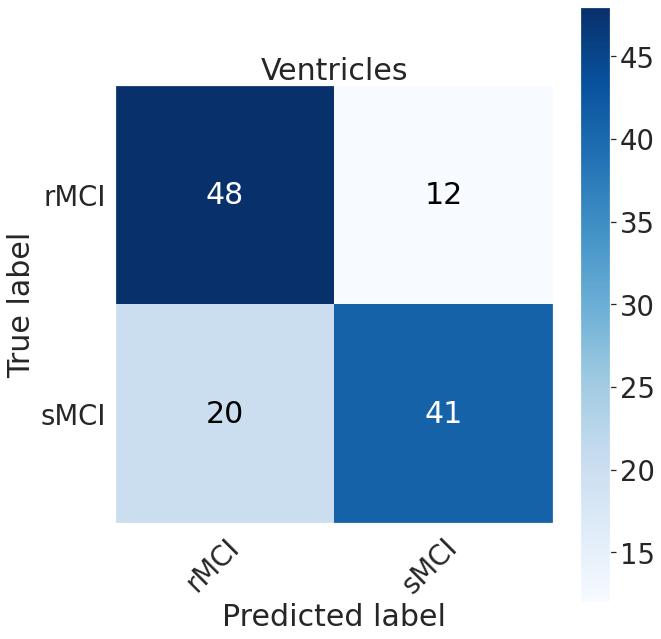

              precision    recall  f1-score   support

        rMCI       0.71      0.80      0.75        60
        sMCI       0.77      0.67      0.72        61

    accuracy                           0.74       121
   macro avg       0.74      0.74      0.73       121
weighted avg       0.74      0.74      0.73       121

Permutation Importance based on Testset



Weight,Feature
0.2298 ± 0.0697,Max_AGE
0.1901 ± 0.0331,AGE_mean
0.1355 ± 0.0800,Age_at_scan
0.0793 ± 0.0386,dev_last
0.0744 ± 0.0724,dev_bl
0.0099 ± 0.0219,Group
-0.0083 ± 0.0234,SEX
-0.0347 ± 0.0423,max_change


In [323]:
roi = 'Ventricles'
rm_cols  = ['DX2N' ,'DX2']

df_roi_trn = train_lin_feat[roi].set_index('RID')
df_roi_tst = test_lin_feat[roi]


################ Train and Test set ############################
X = df_roi_trn.drop(columns=rm_cols)
y = df_roi_trn['DX2']
X_test = df_roi_tst.drop(columns=rm_cols)
y_test = df_roi_tst['DX2']

y = y.map(dic_r)
y_test = y_test.map(dic_r)
################# Corelation Matrix ############################
dic = {'sMCI':1, 'rMCI':2}
y_num = y.map(dic)
corr_df = pd.concat([X,y_num], axis = 1)

correlation_matrix = corr_df.corr()
print(correlation_matrix['DX2'].sort_values(ascending=False))
ax = correlation_matrix.style.background_gradient(cmap='autumn_r').set_precision(2)
display(ax)

################### Cross validation ###########################
models_LV= []
nb_splits = min([y.value_counts().values[i] for i in range(len(y.value_counts()))])
print('number of split', nb_splits)


print('\n ================== Logistic Regession =====================\n')

lr_std = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, solver='lbfgs', max_iter=500))
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': np.linspace(0.1, 21, 20)
}

print('Standard scaler \n')
lr_model_std = run_gridsearch(lr_std, param_grid,X,y, cv=nb_splits, reevaluate=True)

lr_model = lr_model_std
save_model(lr_model, 'logreg_model_Lvent')
models_LV.append(lr_model)
print(f'Logistic Regression score: {lr_model.score(X_test,y_test)}')
miss_lr, test_detail_lr, feature_test_lr=confusion_matrix_permutation(lr_model, X, X_test, y, y_test,roi, label = 'DX2')


print('\n ================== SVM =====================\n')

svm_std = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))
svm_minmax = make_pipeline(MinMaxScaler(), SVC(random_state=42, probability=True))

param_grid = {
    'svc__C': np.linspace(0.1,15, 10), 
    'svc__gamma': ['scale','auto'],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']}

svm_model_std = run_gridsearch(svm_std, param_grid,X , y ,cv=nb_splits, reevaluate=True)
svm_model_minmax = run_gridsearch(svm_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)

svm_model = svm_model_std
save_model(svm_model, 'svm_model_Lvent')
models_LV.append(svm_model)
print(f'SVM score: {svm_model.score(X_test,y_test)}')
miss_svm, test_detail_svm, feature_test_svm = confusion_matrix_permutation(svm_model, X, X_test, y, y_test, roi, label = 'DX2')



print('\n ================== Ensemble Classifier =====================\n')

print('Models: ',models_LV)
eclf_Lvent = evaluate_ensemble(models_LV, X,y ,nb_splits, voting='soft')
save_model(eclf_Lvent, 'ensemble_model_LV_AD')

print(f'Ensemble score on test set: {eclf_Lvent.fit(X,y).score(X_test,y_test)}')
miss_eclf, test_detail_eclf, feature_test_eclf_c2 = confusion_matrix_permutation(eclf_Lvent, X, X_test, y, y_test,roi, label = 'DX2')


number of split 210

 ================== Logistic Regession =====================

Standard scaler 

(431, 8) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    4.9s finished


Best accuracy: 0.7944444444444444
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7944444444444444
Mean train accuracy: 0.7999978733623593
Logistic Regression score: 0.7768595041322314
training score :  0.777
[('rMCI', 60), ('sMCI', 61)]


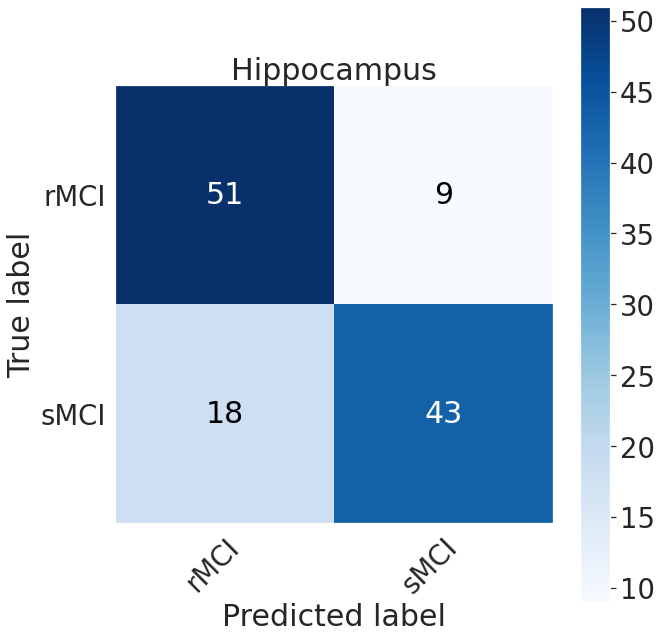

              precision    recall  f1-score   support

        rMCI       0.74      0.85      0.79        60
        sMCI       0.83      0.70      0.76        61

    accuracy                           0.78       121
   macro avg       0.78      0.78      0.78       121
weighted avg       0.78      0.78      0.78       121

Permutation Importance based on Testset



Weight,Feature
0.2793 ± 0.0704,Max_AGE
0.2264 ± 0.0356,AGE_mean
0.1669 ± 0.0243,dev_last
0.0116 ± 0.0198,dev_bl
0.0066 ± 0.0124,max_change
0.0050 ± 0.0081,SEX
0.0050 ± 0.0132,Group
0.0050 ± 0.0169,Age_at_scan



 ================== SVM =====================

(431, 8) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.1min finished


Best accuracy: 0.7547619047619047
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7547619047619047
Mean train accuracy: 0.8078796074123177
(431, 8) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.1min finished


Best accuracy: 0.8015873015873015
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.8015873015873015
Mean train accuracy: 0.8137190950275061
SVM score: 0.7272727272727273
training score :  0.727
[('rMCI', 60), ('sMCI', 61)]


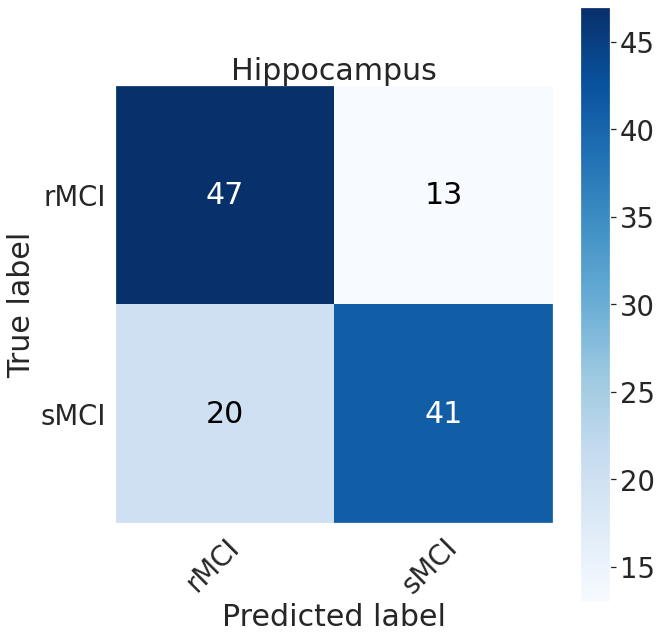

              precision    recall  f1-score   support

        rMCI       0.70      0.78      0.74        60
        sMCI       0.76      0.67      0.71        61

    accuracy                           0.73       121
   macro avg       0.73      0.73      0.73       121
weighted avg       0.73      0.73      0.73       121

Permutation Importance based on Testset



Weight,Feature
0.2314 ± 0.0761,Max_AGE
0.1884 ± 0.0264,AGE_mean
0.1074 ± 0.0905,dev_bl
0.0678 ± 0.0410,dev_last
0.0132 ± 0.0169,max_change
0.0000 ± 0.0105,Age_at_scan
0 ± 0.0000,Group
-0.0215 ± 0.0247,SEX



 ================== Ensemble Classifier =====================

Models:  [Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=8.894444444444444, max_iter=500,
                                    random_state=42))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc',
                 SVC(C=11.115555555555554, kernel='poly', probability=True,
                     random_state=42))])]
Mean test accuracy: 0.7944444444444444
Mean train accuracy: 0.8136524430916953
Ensemble score on test set: 0.7355371900826446
training score :  0.736
[('rMCI', 60), ('sMCI', 61)]


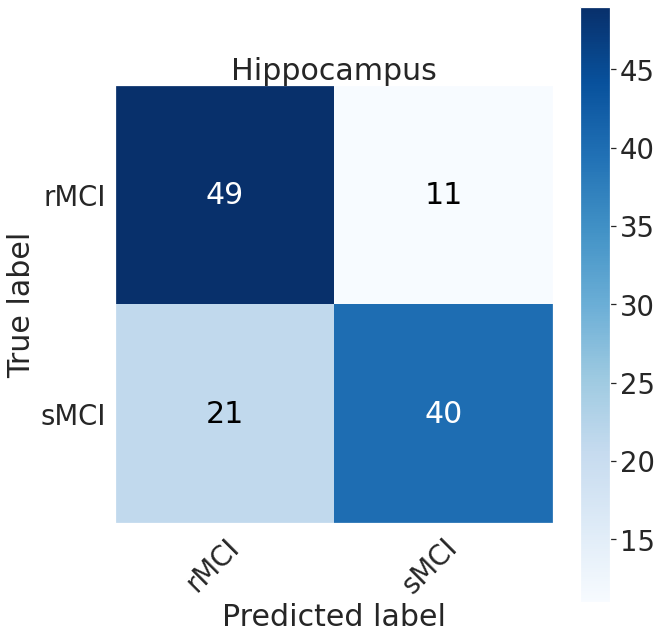

              precision    recall  f1-score   support

        rMCI       0.70      0.82      0.75        60
        sMCI       0.78      0.66      0.71        61

    accuracy                           0.74       121
   macro avg       0.74      0.74      0.73       121
weighted avg       0.74      0.74      0.73       121

Permutation Importance based on Testset



Weight,Feature
0.2430 ± 0.0682,Max_AGE
0.1967 ± 0.0337,AGE_mean
0.0512 ± 0.0284,dev_last
0.0248 ± 0.0468,dev_bl
0.0050 ± 0.0132,max_change
0.0000 ± 0.0148,Group
-0.0083 ± 0.0209,Age_at_scan
-0.0182 ± 0.0321,SEX


In [324]:
roi = 'Hippocampus'
rm_cols  = ['DX2N' ,'DX2']

df_roi_trn = train_lin_feat[roi].set_index('RID')
df_roi_tst = test_lin_feat[roi]


################ Train and Test set ############################
X = df_roi_trn.drop(columns=rm_cols)
y = df_roi_trn['DX2']
X_test = df_roi_tst.drop(columns=rm_cols)
y_test = df_roi_tst['DX2']

y = y.map(dic_r)
y_test = y_test.map(dic_r)

################### Cross validation ###########################
models_LH= []
nb_splits = min([y.value_counts().values[i] for i in range(len(y.value_counts()))])
print('number of split', nb_splits)


print('\n ================== Logistic Regession =====================\n')

lr_std = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, solver='lbfgs', max_iter=500))
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': np.linspace(0.01, 20, 10),
}

print('Standard scaler \n')
lr_model_std = run_gridsearch(lr_std, param_grid,X,y, cv=nb_splits, reevaluate=True)

lr_model = lr_model_std
save_model(lr_model, 'logreg_model_Lhip')
models_LH.append(lr_model)
print(f'Logistic Regression score: {lr_model.score(X_test,y_test)}')
miss_lr, test_detail_lr, feature_test_lr=confusion_matrix_permutation(lr_model, X, X_test, y, y_test,roi, label = 'DX2')


print('\n ================== SVM =====================\n')

svm_std = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))
svm_minmax = make_pipeline(MinMaxScaler(), SVC(random_state=42, probability=True))

param_grid = {
    'svc__C': np.linspace(0.01, 20, 10), 
    'svc__gamma': ['scale','auto'],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']}

svm_model_std = run_gridsearch(svm_std, param_grid,X , y ,cv=nb_splits, reevaluate=True)
svm_model_minmax = run_gridsearch(svm_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)

svm_model = svm_model_minmax
save_model(svm_model, 'svm_model_Lhip')
models_LH.append(svm_model)
print(f'SVM score: {svm_model.score(X_test,y_test)}')
miss_svm, test_detail_svm, feature_test_svm = confusion_matrix_permutation(svm_model, X, X_test, y, y_test, roi, label = 'DX2')


print('\n ================== Ensemble Classifier =====================\n')

print('Models: ',models_LH)
eclf_Lhip = evaluate_ensemble(models_LH, X,y ,nb_splits, voting='soft')
save_model(eclf_Lhip, 'ensemble_model_LH_AD')

print(f'Ensemble score on test set: {eclf_Lhip.fit(X,y).score(X_test,y_test)}')
miss_eclf, test_detail_eclf, feature_test_eclf_c2 = confusion_matrix_permutation(eclf_Lhip, X, X_test, y, y_test,roi, label = 'DX2')


## Nonlinear

number of split 210

 ================== Logistic Regession =====================

Standard scaler 

(431, 9) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    5.2s finished


Best accuracy: 0.7880952380952381
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7880952380952381
Mean train accuracy: 0.7907614711353028
(431, 9) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    6.1s finished


Best accuracy: 0.6833333333333333
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.6833333333333333
Mean train accuracy: 0.6930248619500956
Logistic Regression score: 0.6528925619834711
training score :  0.653
[('rMCI', 60), ('sMCI', 61)]


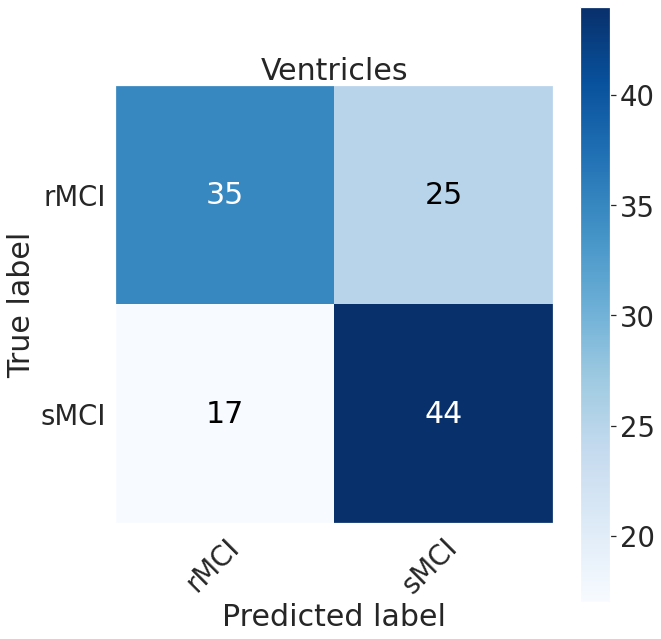

              precision    recall  f1-score   support

        rMCI       0.67      0.58      0.63        60
        sMCI       0.64      0.72      0.68        61

    accuracy                           0.65       121
   macro avg       0.66      0.65      0.65       121
weighted avg       0.66      0.65      0.65       121

Permutation Importance based on Testset



Weight,Feature
0.1719 ± 0.0595,Max_AGE
0.1091 ± 0.0799,AGE_mean
0.0331 ± 0.0347,max_change
0.0248 ± 0.0512,dev_bl
0.0116 ± 0.0169,SEX
0.0099 ± 0.0243,dev_last
0.0000 ± 0.0296,AGE2
-0.0083 ± 0.0331,Age_at_scan
-0.0149 ± 0.0162,Group



 ================== SVM =====================

(431, 9) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.0min finished


Best accuracy: 0.7158730158730158
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7158730158730158
Mean train accuracy: 0.8079019630421499
(431, 9) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 12136 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.3min finished


Best accuracy: 0.792063492063492
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.792063492063492
Mean train accuracy: 0.8173491876762904
SVM score: 0.7355371900826446
training score :  0.736
[('rMCI', 60), ('sMCI', 61)]


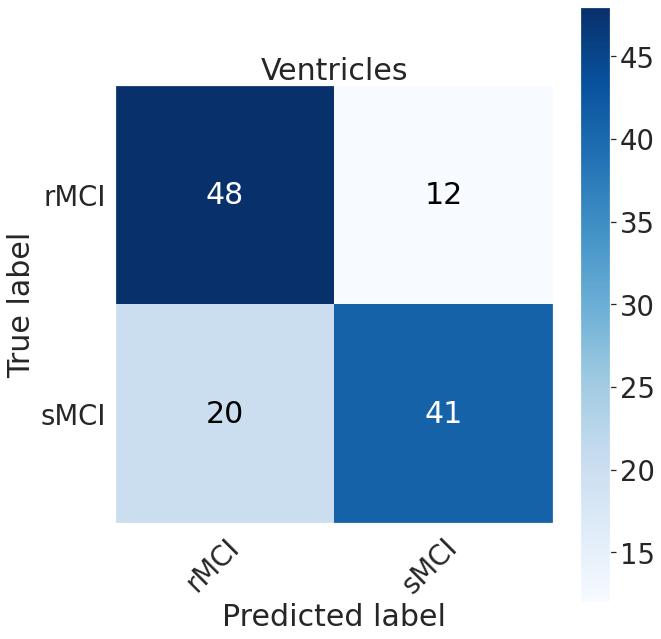

              precision    recall  f1-score   support

        rMCI       0.71      0.80      0.75        60
        sMCI       0.77      0.67      0.72        61

    accuracy                           0.74       121
   macro avg       0.74      0.74      0.73       121
weighted avg       0.74      0.74      0.73       121

Permutation Importance based on Testset



Weight,Feature
0.2562 ± 0.0636,Max_AGE
0.2000 ± 0.1032,AGE_mean
0.0413 ± 0.0181,dev_last
0.0413 ± 0.0391,dev_bl
0.0215 ± 0.0340,Age_at_scan
0.0198 ± 0.0779,Group
0.0149 ± 0.0243,AGE2
0.0116 ± 0.0269,max_change
0.0033 ± 0.0307,SEX



 ================== Ensemble Classifier =====================

Models:  [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=8.9, max_iter=500, random_state=42))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc',
                 SVC(C=4.5, kernel='poly', probability=True, random_state=42))])]
Mean test accuracy: 0.7761904761904762
Mean train accuracy: 0.7969671553783704
Ensemble score on test set: 0.7272727272727273
training score :  0.727
[('rMCI', 60), ('sMCI', 61)]


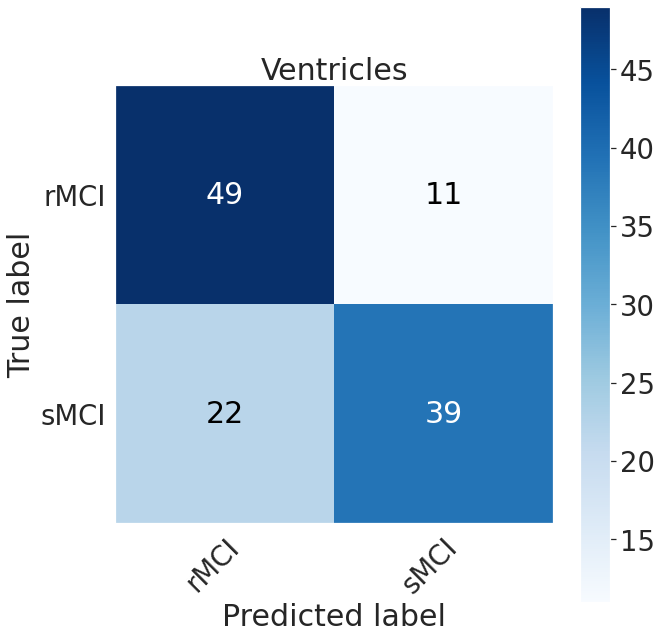

              precision    recall  f1-score   support

        rMCI       0.69      0.82      0.75        60
        sMCI       0.78      0.64      0.70        61

    accuracy                           0.73       121
   macro avg       0.74      0.73      0.73       121
weighted avg       0.74      0.73      0.73       121

Permutation Importance based on Testset



Weight,Feature
0.2430 ± 0.0615,Max_AGE
0.1851 ± 0.0927,AGE_mean
0.0496 ± 0.0582,dev_bl
0.0281 ± 0.0269,dev_last
0.0215 ± 0.0169,AGE2
0.0017 ± 0.0284,SEX
-0.0050 ± 0.0132,Age_at_scan
-0.0066 ± 0.0193,max_change
-0.0132 ± 0.0426,Group


In [325]:
roi = 'Ventricles'
rm_cols  = ['DX2N' ,'DX2']

dfn_roi_trn = train_Nlin_feat[roi].set_index('RID')
dfn_roi_tst = test_Nlin_feat[roi]


################ Train and Test set ############################
X = dfn_roi_trn.drop(columns=rm_cols)
y = dfn_roi_trn['DX2']
X_test = dfn_roi_tst.drop(columns=rm_cols)
y_test = dfn_roi_tst['DX2']

y = y.map(dic_r)
y_test = y_test.map(dic_r)
################### Cross validation ###########################
models_NlV= []
nb_splits = min([y.value_counts().values[i] for i in range(len(y.value_counts()))])
print('number of split', nb_splits)


print('\n ================== Logistic Regession =====================\n')

lr_std = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, solver='lbfgs', max_iter=500))
lr_minmax = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42,  solver='lbfgs', max_iter=500))
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': np.linspace(0.1, 10, 10)
}

print('Standard scaler \n')
lr_model_std = run_gridsearch(lr_std, param_grid,X,y, cv=nb_splits, reevaluate=True)
lr_model_minmax = run_gridsearch(lr_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)
lr_model = lr_model_minmax
save_model(lr_model, 'logreg_model_Lvent')
models_NlV.append(lr_model)
print(f'Logistic Regression score: {lr_model.score(X_test,y_test)}')
miss_lr, test_detail_lr, feature_test_lr=confusion_matrix_permutation(lr_model, X, X_test, y, y_test,roi, label = 'DX2')


print('\n ================== SVM =====================\n')

svm_std = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))
svm_minmax = make_pipeline(MinMaxScaler(), SVC(random_state=42, probability=True))

param_grid = {
    'svc__C':  np.linspace(0.1, 10, 10), 
    'svc__gamma': ['scale','auto'],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']}

svm_model_std = run_gridsearch(svm_std, param_grid,X , y ,cv=nb_splits, reevaluate=True)
svm_model_minmax = run_gridsearch(svm_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)

svm_model = svm_model_minmax
save_model(svm_model, 'svm_model_Lvent')
models_NlV.append(svm_model)
print(f'SVM score: {svm_model.score(X_test,y_test)}')
miss_svm, test_detail_svm, feature_test_svm = confusion_matrix_permutation(svm_model, X, X_test, y, y_test, roi, label = 'DX2')



print('\n ================== Ensemble Classifier =====================\n')

print('Models: ',models_NlV)
eclf_Nlvent = evaluate_ensemble(models_NlV, X,y ,nb_splits, voting='soft')
save_model(eclf_Nlvent, 'ensemble_model_NlV_AD')

print(f'Ensemble score on test set: {eclf_Nlvent.fit(X,y).score(X_test,y_test)}')
miss_eclf, test_detail_eclf, feature_test_eclf_c2 = confusion_matrix_permutation(eclf_Nlvent, X, X_test, y, y_test,roi, label = 'DX2')


number of split 210

 ================== Logistic Regession =====================

Standard scaler 

(431, 9) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    5.3s finished


Best accuracy: 0.792063492063492
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.792063492063492
Mean train accuracy: 0.798599064486915
Logistic Regression score: 0.7603305785123967
training score :  0.76
[('rMCI', 60), ('sMCI', 61)]


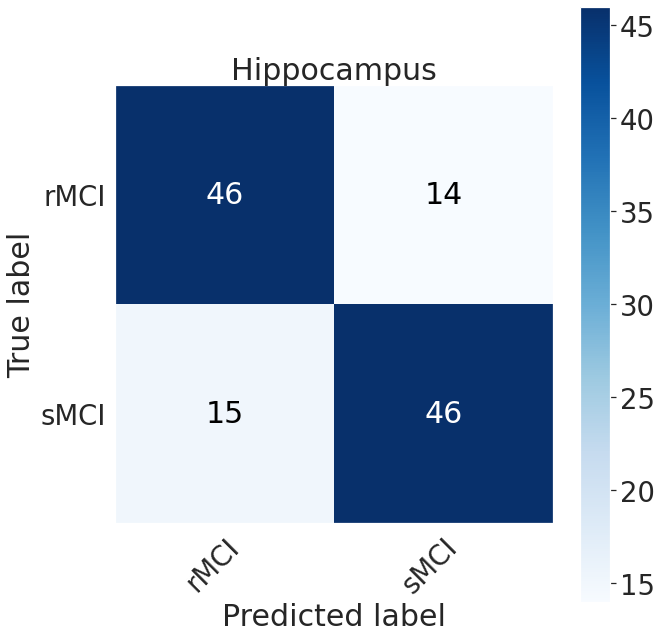

              precision    recall  f1-score   support

        rMCI       0.75      0.77      0.76        60
        sMCI       0.77      0.75      0.76        61

    accuracy                           0.76       121
   macro avg       0.76      0.76      0.76       121
weighted avg       0.76      0.76      0.76       121

Permutation Importance based on Testset



Weight,Feature
0.2694 ± 0.0615,Max_AGE
0.2149 ± 0.0803,AGE_mean
0.1736 ± 0.0331,dev_last
0.0066 ± 0.0321,dev_bl
0.0050 ± 0.0081,Age_at_scan
0.0033 ± 0.0081,AGE2
0.0000 ± 0.0209,SEX
-0.0033 ± 0.0288,Group
-0.0050 ± 0.0198,max_change



 ================== SVM =====================

(431, 9) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:   55.7s finished


Best accuracy: 0.7460317460317459
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7460317460317459
Mean train accuracy: 0.7920492539651418
(431, 9) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.1min finished


Best accuracy: 0.7968253968253968
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7968253968253968
Mean train accuracy: 0.8054707753305883
SVM score: 0.71900826446281
training score :  0.719
[('rMCI', 60), ('sMCI', 61)]


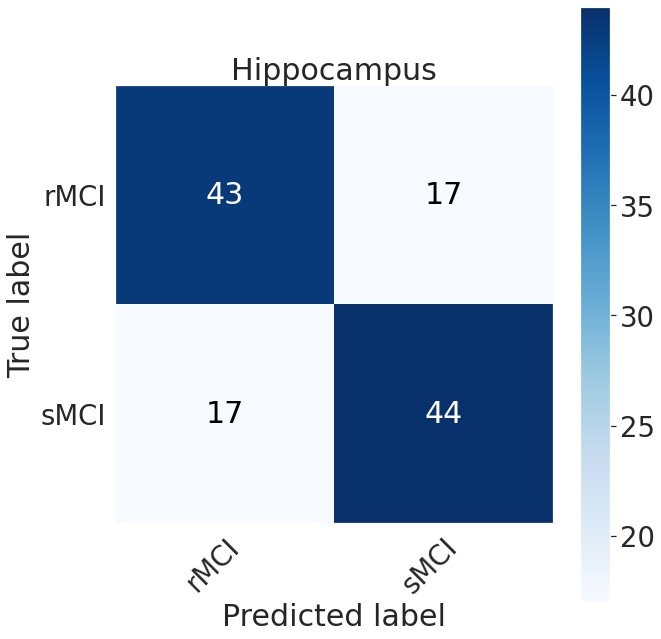

              precision    recall  f1-score   support

        rMCI       0.72      0.72      0.72        60
        sMCI       0.72      0.72      0.72        61

    accuracy                           0.72       121
   macro avg       0.72      0.72      0.72       121
weighted avg       0.72      0.72      0.72       121

Permutation Importance based on Testset



Weight,Feature
0.2215 ± 0.0576,Max_AGE
0.1802 ± 0.0908,AGE_mean
0.0397 ± 0.0613,dev_bl
0.0248 ± 0.0418,dev_last
-0.0033 ± 0.0224,max_change
-0.0033 ± 0.0426,Age_at_scan
-0.0132 ± 0.0169,AGE2
-0.0231 ± 0.0303,Group
-0.0248 ± 0.0418,SEX



 ================== Ensemble Classifier =====================

Models:  [Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=7.78, max_iter=500, random_state=42))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc',
                 SVC(C=2.23, kernel='poly', probability=True,
                     random_state=42))])]
Mean test accuracy: 0.792063492063492
Mean train accuracy: 0.8060923240829782
Ensemble score on test set: 0.768595041322314
training score :  0.769
[('rMCI', 60), ('sMCI', 61)]


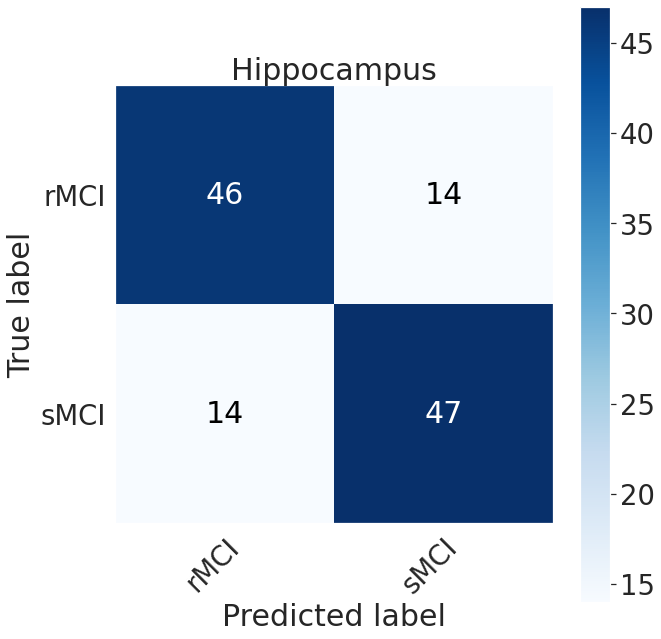

              precision    recall  f1-score   support

        rMCI       0.77      0.77      0.77        60
        sMCI       0.77      0.77      0.77        61

    accuracy                           0.77       121
   macro avg       0.77      0.77      0.77       121
weighted avg       0.77      0.77      0.77       121

Permutation Importance based on Testset



Weight,Feature
0.2760 ± 0.0559,Max_AGE
0.2314 ± 0.0905,AGE_mean
0.1008 ± 0.0397,dev_last
0.0281 ± 0.0169,max_change
0.0198 ± 0.0247,dev_bl
0.0066 ± 0.0066,Age_at_scan
0 ± 0.0000,AGE2
-0.0033 ± 0.0081,Group
-0.0033 ± 0.0247,SEX


In [326]:
roi = 'Hippocampus'
rm_cols  = ['DX2N' ,'DX2']

dfn_roi_trn = train_Nlin_feat[roi].set_index('RID')
dfn_roi_tst = test_Nlin_feat[roi]


################ Train and Test set ############################
X = dfn_roi_trn.drop(columns=rm_cols)
y = dfn_roi_trn['DX2']
X_test = dfn_roi_tst.drop(columns=rm_cols)
y_test = dfn_roi_tst['DX2']

y = y.map(dic_r)
y_test = y_test.map(dic_r)
################### Cross validation ###########################
models_NlH= []
nb_splits = min([y.value_counts().values[i] for i in range(len(y.value_counts()))])
print('number of split', nb_splits)


print('\n ================== Logistic Regession =====================\n')

lr_std = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, solver='lbfgs', max_iter=500))
lr_minmax = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42,  solver='lbfgs', max_iter=500))
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': np.linspace(0.01, 10, 10)
}
print('Standard scaler \n')
lr_model_std = run_gridsearch(lr_std, param_grid,X,y, cv=nb_splits, reevaluate=True)

lr_model = lr_model_std
save_model(lr_model, 'logreg_model_Nlhip')
models_NlH.append(lr_model)
print(f'Logistic Regression score: {lr_model.score(X_test,y_test)}')
miss_lr, test_detail_lr, feature_test_lr=confusion_matrix_permutation(lr_model, X, X_test, y, y_test,roi, label = 'DX2')

print('\n ================== SVM =====================\n')

svm_std = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))
svm_minmax = make_pipeline(MinMaxScaler(), SVC(random_state=42, probability=True))

param_grid = {
    'svc__C': np.linspace(0.01, 10, 10), 
    'svc__gamma': ['scale','auto'],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']}

svm_model_std = run_gridsearch(svm_std, param_grid,X , y ,cv=nb_splits, reevaluate=True)
svm_model_minmax = run_gridsearch(svm_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)

svm_model = svm_model_minmax
save_model(svm_model, 'svm_model_Nlhip')
models_NlH.append(svm_model)
print(f'SVM score: {svm_model.score(X_test,y_test)}')
miss_svm, test_detail_svm, feature_test_svm = confusion_matrix_permutation(svm_model, X, X_test, y, y_test, roi, label = 'DX2')


print('\n ================== Ensemble Classifier =====================\n')

print('Models: ',models_NlH)
eclf_Nlhip = evaluate_ensemble(models_NlH, X,y ,nb_splits, voting='soft')
save_model(eclf_Nlhip, 'ensemble_model_NlH_AD')

print(f'Ensemble score on test set: {eclf_Nlhip.fit(X,y).score(X_test,y_test)}')
miss_eclf, test_detail_eclf, feature_test_eclf_c2 = confusion_matrix_permutation(eclf_Nlhip, X, X_test, y, y_test,roi, label = 'DX2')


number of split 210

 ================== Logistic Regession =====================

Standard scaler 

(431, 9) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    4.4s finished


Best accuracy: 0.792063492063492
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.792063492063492
Mean train accuracy: 0.7985102384635094
Logistic Regression score: 0.7603305785123967
training score :  0.76
[('cAD', 60), ('sMCI', 61)]


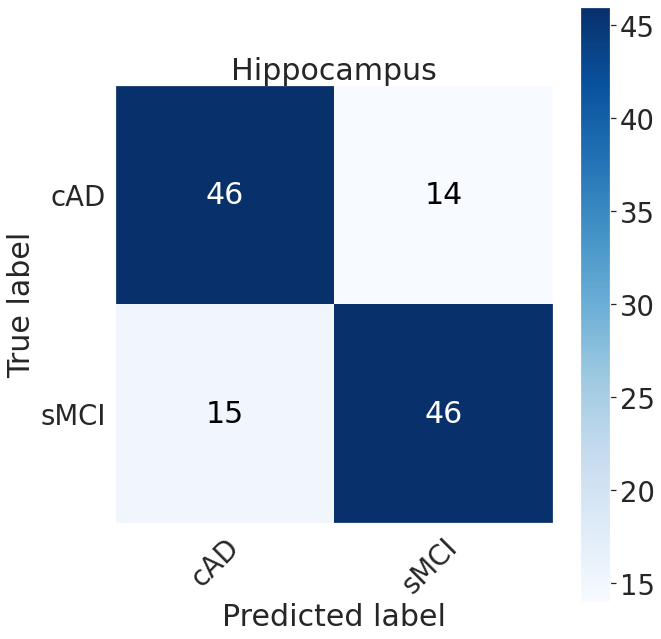

              precision    recall  f1-score   support

         cAD       0.75      0.77      0.76        60
        sMCI       0.77      0.75      0.76        61

    accuracy                           0.76       121
   macro avg       0.76      0.76      0.76       121
weighted avg       0.76      0.76      0.76       121

Permutation Importance based on Testset



Weight,Feature
0.2694 ± 0.0615,Max_AGE
0.2149 ± 0.0803,AGE_mean
0.1736 ± 0.0331,dev_last
0.0066 ± 0.0321,dev_bl
0.0050 ± 0.0081,Age_at_scan
0.0033 ± 0.0081,AGE2
0.0000 ± 0.0209,SEX
-0.0033 ± 0.0288,Group
-0.0066 ± 0.0193,max_change



 ================== SVM =====================

(431, 9) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:   54.1s finished


Best accuracy: 0.7460317460317459
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7460317460317459
Mean train accuracy: 0.7926154064004532
(431, 9) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.1min finished


Best accuracy: 0.7968253968253968
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7968253968253968
Mean train accuracy: 0.8055041012984938
SVM score: 0.71900826446281
training score :  0.719
[('cAD', 60), ('sMCI', 61)]


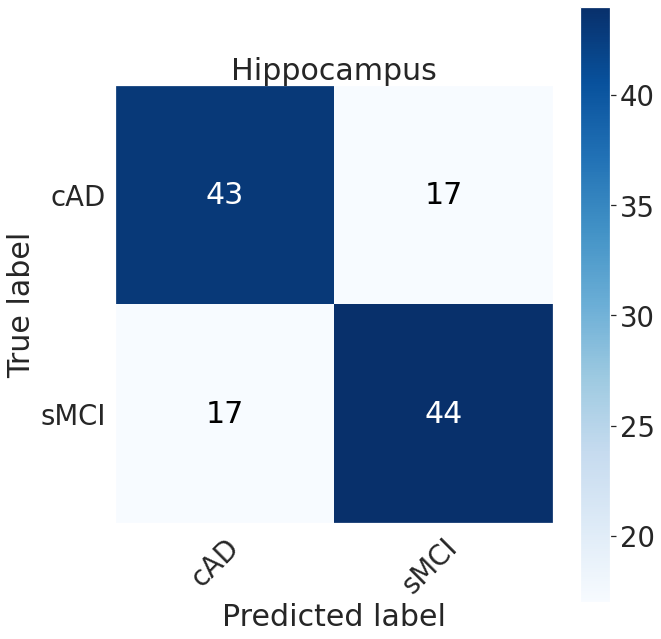

              precision    recall  f1-score   support

         cAD       0.72      0.72      0.72        60
        sMCI       0.72      0.72      0.72        61

    accuracy                           0.72       121
   macro avg       0.72      0.72      0.72       121
weighted avg       0.72      0.72      0.72       121

Permutation Importance based on Testset



Weight,Feature
0.2215 ± 0.0576,Max_AGE
0.1802 ± 0.0908,AGE_mean
0.0413 ± 0.0618,dev_bl
0.0281 ± 0.0324,dev_last
-0.0017 ± 0.0423,Age_at_scan
-0.0033 ± 0.0247,max_change
-0.0099 ± 0.0219,AGE2
-0.0248 ± 0.0418,SEX
-0.0248 ± 0.0277,Group



 ================== Ensemble Classifier =====================

Models:  [Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=7.800000000000001, max_iter=500,
                                    random_state=42))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc',
                 SVC(C=2.3000000000000003, kernel='poly', probability=True,
                     random_state=42))])]
Mean test accuracy: 0.792063492063492
Mean train accuracy: 0.8063809243715785
Ensemble score on test set: 0.768595041322314
training score :  0.769
[('cAD', 60), ('sMCI', 61)]


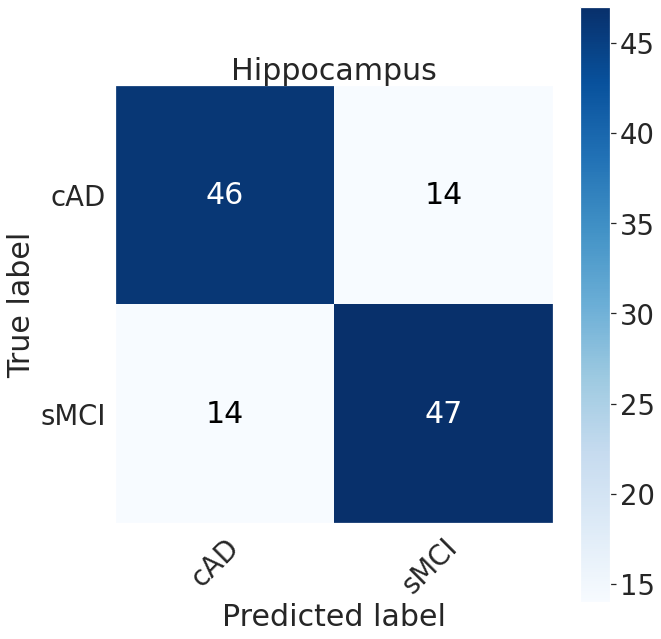

              precision    recall  f1-score   support

         cAD       0.77      0.77      0.77        60
        sMCI       0.77      0.77      0.77        61

    accuracy                           0.77       121
   macro avg       0.77      0.77      0.77       121
weighted avg       0.77      0.77      0.77       121

Permutation Importance based on Testset



Weight,Feature
0.2760 ± 0.0559,Max_AGE
0.2314 ± 0.0905,AGE_mean
0.1008 ± 0.0436,dev_last
0.0281 ± 0.0169,max_change
0.0198 ± 0.0247,dev_bl
0.0083 ± 0.0105,Age_at_scan
0 ± 0.0000,AGE2
-0.0050 ± 0.0132,Group
-0.0083 ± 0.0256,SEX


In [99]:
roi = 'Hippocampus'
rm_cols  = ['DX2N' ,'DX2']

dfn_roi_trn = train_Nlin_feat[roi].set_index('RID')
dfn_roi_tst = test_Nlin_feat[roi]


################ Train and Test set ############################
X = dfn_roi_trn.drop(columns=rm_cols)
y = dfn_roi_trn['DX2']
X_test = dfn_roi_tst.drop(columns=rm_cols)
y_test = dfn_roi_tst['DX2']


################### Cross validation ###########################
models= []
nb_splits = min([y.value_counts().values[i] for i in range(len(y.value_counts()))])
print('number of split', nb_splits)


print('\n ================== Logistic Regession =====================\n')

lr_std = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, solver='lbfgs', max_iter=500))
lr_minmax = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42,  solver='lbfgs', max_iter=500))
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': np.linspace(0.1, 10, 10)
}
print('Standard scaler \n')
lr_model_std = run_gridsearch(lr_std, param_grid,X,y, cv=nb_splits, reevaluate=True)

lr_model = lr_model_std
save_model(lr_model, 'logreg_model_Lvent')
models.append(lr_model)
print(f'Logistic Regression score: {lr_model.score(X_test,y_test)}')
miss_lr, test_detail_lr, feature_test_lr=confusion_matrix_permutation(lr_model, X, X_test, y, y_test,roi, label = 'DX2')

print('\n ================== SVM =====================\n')

svm_std = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))
svm_minmax = make_pipeline(MinMaxScaler(), SVC(random_state=42, probability=True))

param_grid = {
    'svc__C': np.linspace(0.1, 10, 10), 
    'svc__gamma': ['scale','auto'],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']}

svm_model_std = run_gridsearch(svm_std, param_grid,X , y ,cv=nb_splits, reevaluate=True)
svm_model_minmax = run_gridsearch(svm_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)

svm_model = svm_model_minmax
save_model(svm_model, 'svm_model_Lvent')
models.append(svm_model)
print(f'SVM score: {svm_model.score(X_test,y_test)}')
miss_svm, test_detail_svm, feature_test_svm = confusion_matrix_permutation(svm_model, X, X_test, y, y_test, roi, label = 'DX2')


print('\n ================== Ensemble Classifier =====================\n')

print('Models: ',models)
eclf_Lvent = evaluate_ensemble(models, X,y ,nb_splits, voting='soft')
save_model(eclf_Lvent, 'ensemble_model_cog')

print(f'Ensemble score on test set: {eclf_Lvent.fit(X,y).score(X_test,y_test)}')
miss_eclf, test_detail_eclf, feature_test_eclf_c2 = confusion_matrix_permutation(eclf_Lvent, X, X_test, y, y_test,roi, label = 'DX2')


## Combine Ventricles and Hippocampi


 Same order for features is True
(431, 8) (431, 9)
Same order for labels is True

 Same order for features is True
(121, 8) (121, 9)
Same order for labels is True
number of split 210

 ================== Logistic Regession =====================

Standard scaler 

(431, 14) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1456 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    6.4s finished


Best accuracy: 0.7873015873015872
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7873015873015872
Mean train accuracy: 0.7973892929500407
(431, 14) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1456 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    6.9s finished


Best accuracy: 0.765079365079365
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.765079365079365
Mean train accuracy: 0.7679593511369214
Logistic Regression score: 0.7768595041322314
training score :  0.777
[('rMCI', 60), ('sMCI', 61)]


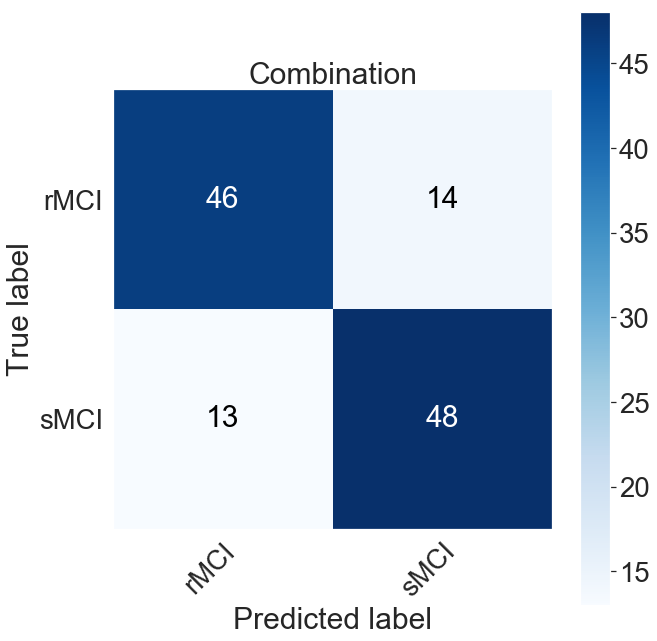

              precision    recall  f1-score   support

        rMCI       0.78      0.77      0.77        60
        sMCI       0.77      0.79      0.78        61

    accuracy                           0.78       121
   macro avg       0.78      0.78      0.78       121
weighted avg       0.78      0.78      0.78       121

Permutation Importance based on Testset



Weight,Feature
0.2793 ± 0.0778,Current_Age
0.2397 ± 0.0686,AGE_mean
0.1669 ± 0.0908,dev_last_Hipp
0.0612 ± 0.0497,dev_last_Vent
0.0331 ± 0.0277,slop_Vent
0.0248 ± 0.0405,dev_bl_Vent
0.0198 ± 0.0081,slop_Hipp
0.0116 ± 0.0169,Group_Vent
0.0099 ± 0.0284,SEX
0.0083 ± 0.0181,random_slope_Vent



 ================== SVM =====================

(431, 14) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1456 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 4756 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 7956 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 9856 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 11956 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:   43.4s finished


Best accuracy: 0.7436507936507936
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7436507936507936
Mean train accuracy: 0.8369431451207152
(431, 14) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1456 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2356 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 4756 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 7956 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 9856 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 11956 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:   50.4s finished


Best accuracy: 0.7817460317460317
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7817460317460317
Mean train accuracy: 0.8279062837474055
SVM score: 0.7024793388429752
training score :  0.702
[('rMCI', 60), ('sMCI', 61)]


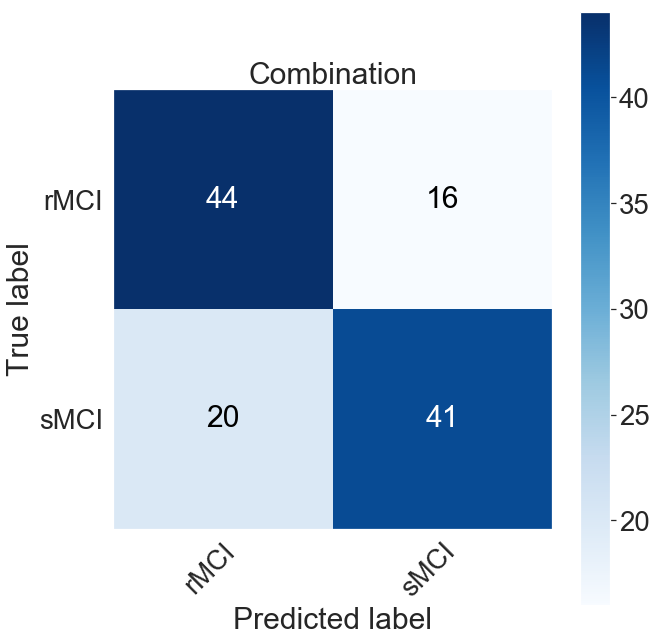

              precision    recall  f1-score   support

        rMCI       0.69      0.73      0.71        60
        sMCI       0.72      0.67      0.69        61

    accuracy                           0.70       121
   macro avg       0.70      0.70      0.70       121
weighted avg       0.70      0.70      0.70       121

Permutation Importance based on Testset



Weight,Feature
0.2132 ± 0.0704,Current_Age
0.1818 ± 0.0709,AGE_mean
0.0727 ± 0.0673,dev_bl_Hipp
0.0512 ± 0.0448,dev_last_Vent
0.0182 ± 0.0219,AGE2_Vent
0.0132 ± 0.0307,dev_last_Hipp
0.0099 ± 0.0303,Group_Vent
0.0050 ± 0.0132,random_slope_Hipp
0.0033 ± 0.0081,Group_Hipp
-0.0050 ± 0.0307,random_slope_Vent



 ================== Ensemble Classifier =====================

Models:  [Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=7.800000000000001, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=500, multi_class='auto',
                                    n_jobs=None, penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False), Pipeline(memory=None,
         steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svc',
                 SVC(C=3.4000000000000004, break_ties=False, cache_size=200,
                     class_

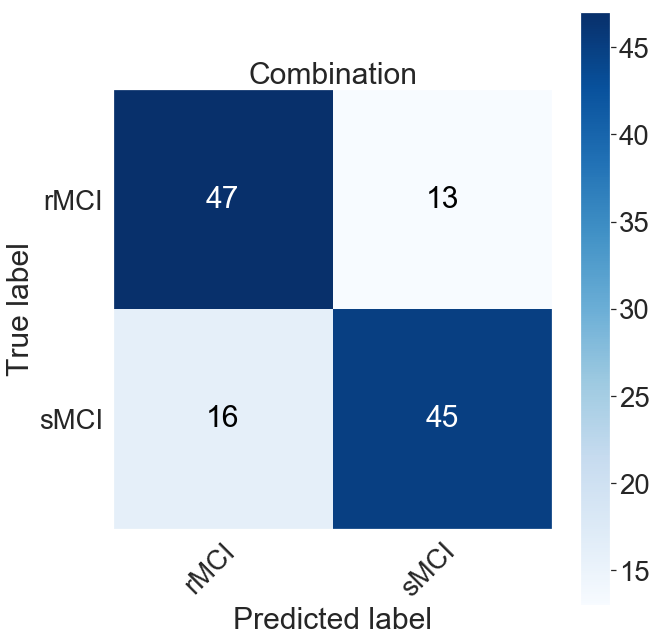

              precision    recall  f1-score   support

        rMCI       0.75      0.78      0.76        60
        sMCI       0.78      0.74      0.76        61

    accuracy                           0.76       121
   macro avg       0.76      0.76      0.76       121
weighted avg       0.76      0.76      0.76       121

Permutation Importance based on Testset



Weight,Feature
0.2661 ± 0.0613,Current_Age
0.2314 ± 0.0732,AGE_mean
0.0777 ± 0.0529,dev_last_Vent
0.0463 ± 0.0674,dev_last_Hipp
0.0430 ± 0.0410,dev_bl_Hipp
0.0413 ± 0.0314,Group_Vent
0.0264 ± 0.0622,dev_bl_Vent
0.0132 ± 0.0324,AGE2_Vent
0.0000 ± 0.0277,random_slope_Vent
-0.0017 ± 0.0124,slop_Vent


In [46]:
roi = 'Combination'
roi1 = 'Hippocampus'
roi2 = 'Ventricles'
rm_cols = ['AGE_mean','Max_AGE', 'DX2', 'DX2N', 'SEX']

##############Train Set ##############

dic1 =  train_lin_feat
dic2 =train_Nlin_feat

X,y =combine_ROIs(dic1, dic2, roi1,roi2,rm_cols,'DX2')

dic_r = {'sMCI':'sMCI', 'cAD':'rMCI'}
y = y.map(dic_r)
############# Test set ##############
dic1_test =  test_lin_feat
dic2_test =test_Nlin_feat

X_test,y_test = combine_ROIs(dic1_test, dic2_test, roi1,roi2,rm_cols,'DX2')
y_test = y_test.map(dic_r)
################### Cross validation ###########################
modelsLN= []
nb_splits = min([y.value_counts().values[i] for i in range(len(y.value_counts()))])
print('number of split', nb_splits)


print('\n ================== Logistic Regession =====================\n')

lr_std = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, solver='lbfgs', max_iter=500))
lr_minmax = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42,  solver='lbfgs', max_iter=500))
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': np.linspace(0.1, 10, 10)
}

print('Standard scaler \n')
lr_model_std = run_gridsearch(lr_std, param_grid,X,y, cv=nb_splits, reevaluate=True)
lr_model_minmax = run_gridsearch(lr_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)
lr_model = lr_model_std
#save_model(lr_model, 'logreg_model_Lvent')
modelsLN.append(lr_model)
print(f'Logistic Regression score: {lr_model.score(X_test,y_test)}')


roi = 'Combination'
miss_lr, test_detail_lr, feature_test_lr=confusion_matrix_permutation(lr_model, X, X_test, y, y_test,roi, label = 'DX2')


print('\n ================== SVM =====================\n')

svm_std = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))
svm_minmax = make_pipeline(MinMaxScaler(), SVC(random_state=42, probability=True))

param_grid = {
    'svc__C':  np.linspace(0.1, 10, 10), 
    'svc__gamma': ['scale','auto'],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']}

svm_model_std = run_gridsearch(svm_std, param_grid,X , y ,cv=nb_splits, reevaluate=True)
svm_model_minmax = run_gridsearch(svm_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)

svm_model = svm_model_minmax
#save_model(svm_model, 'svm_model_Lvent')
modelsLN.append(svm_model)
print(f'SVM score: {svm_model.score(X_test,y_test)}')
miss_svm, test_detail_svm, feature_test_svm = confusion_matrix_permutation(svm_model, X, X_test, y, y_test, roi, label = 'DX2')



print('\n ================== Ensemble Classifier =====================\n')

print('Models: ',modelsLN)
eclf_LN = evaluate_ensemble(modelsLN, X,y ,nb_splits, voting='soft')
save_model(eclf_LN, 'ensemble_model_LHip_NL_Vent_AD')

print(f'Ensemble score on test set: {eclf_LN.fit(X,y).score(X_test,y_test)}')
miss_eclf, test_detail_eclf, feature_test_eclf_c2 = confusion_matrix_permutation(eclf_LN, X, X_test, y, y_test,'Combination', label = 'DX2')

**Combination of features extracted from linear mixed effects model for Hippocampi and Ventricles.**


 Same order for features is True
(431, 8) (431, 8)
Same order for labels is True

 Same order for features is True
(121, 8) (121, 8)
Same order for labels is True
number of split 210

 ================== Logistic Regession =====================

Standard scaler 

(431, 13) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 748 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    7.4s finished


Best accuracy: 0.7912698412698412
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7912698412698412
Mean train accuracy: 0.8040053923231494
(431, 13) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    6.5s finished


Best accuracy: 0.7666666666666667
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7666666666666667
Mean train accuracy: 0.7759301446217335
Logistic Regression score: 0.7520661157024794
training score :  0.752
[('rMCI', 60), ('sMCI', 61)]


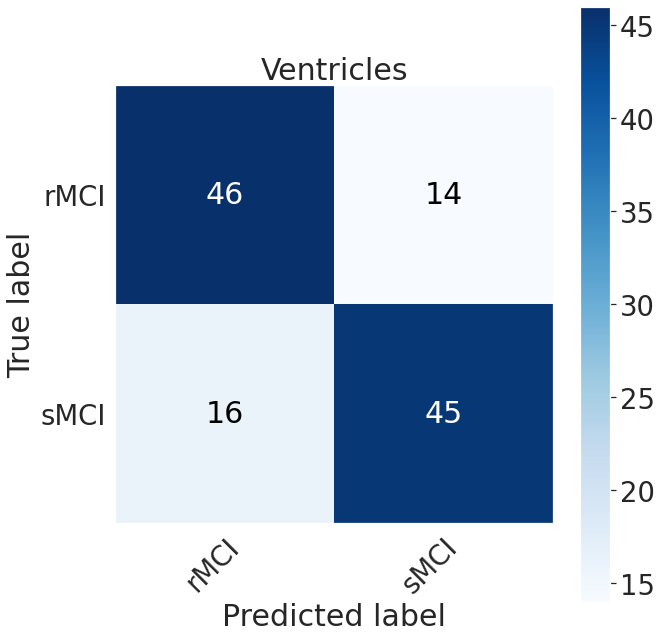

              precision    recall  f1-score   support

        rMCI       0.74      0.77      0.75        60
        sMCI       0.76      0.74      0.75        61

    accuracy                           0.75       121
   macro avg       0.75      0.75      0.75       121
weighted avg       0.75      0.75      0.75       121

Permutation Importance based on Testset



Weight,Feature
0.2678 ± 0.0866,Current_Age
0.2099 ± 0.0649,AGE_mean
0.1140 ± 0.0604,dev_last_Hipp
0.0496 ± 0.0277,random_slope_Vent
0.0298 ± 0.0779,Group_Vent
0.0132 ± 0.0439,dev_bl_Vent
0.0099 ± 0.0066,SEX
0.0066 ± 0.0193,random_slope_Hipp
0.0050 ± 0.0132,dev_bl_Hipp
-0.0017 ± 0.0124,Group_Hipp



 ================== SVM =====================

(431, 13) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:   56.9s finished


Best accuracy: 0.7626984126984127
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7626984126984127
Mean train accuracy: 0.8517635531654222
(431, 13) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.1min finished


Best accuracy: 0.7912698412698412
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7912698412698412
Mean train accuracy: 0.8215677365210075
SVM score: 0.71900826446281
training score :  0.719
[('rMCI', 60), ('sMCI', 61)]


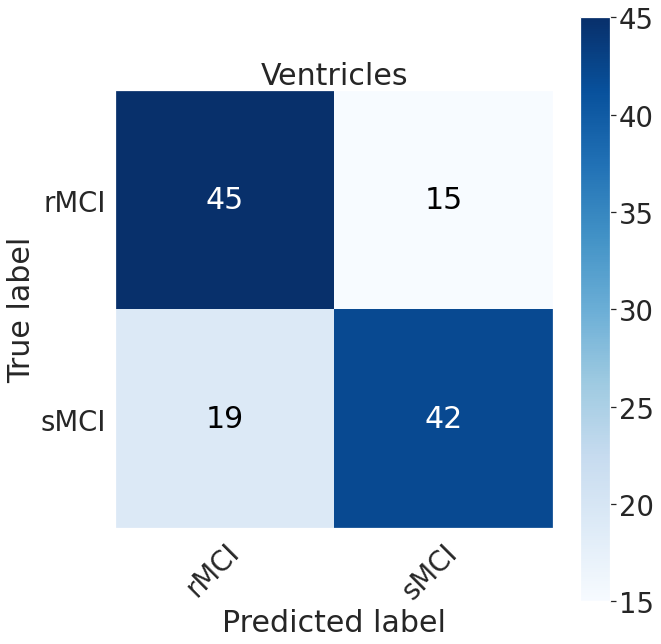

              precision    recall  f1-score   support

        rMCI       0.70      0.75      0.73        60
        sMCI       0.74      0.69      0.71        61

    accuracy                           0.72       121
   macro avg       0.72      0.72      0.72       121
weighted avg       0.72      0.72      0.72       121

Permutation Importance based on Testset



Weight,Feature
0.2331 ± 0.0639,Current_Age
0.1769 ± 0.0641,AGE_mean
0.1355 ± 0.0786,dev_bl_Hipp
0.0479 ± 0.0604,dev_last_Vent
0.0446 ± 0.0224,random_slope_Vent
0.0314 ± 0.0735,dev_bl_Vent
0.0298 ± 0.0356,Group_Vent
0.0050 ± 0.0340,dev_last_Hipp
-0.0033 ± 0.0307,SEX
-0.0033 ± 0.0081,random_slope_Hipp



 ================== Ensemble Classifier =====================

Models:  [Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=6.7, max_iter=500, random_state=42))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc',
                 SVC(C=2.3000000000000003, kernel='poly', probability=True,
                     random_state=42))])]
Mean test accuracy: 0.7904761904761904
Mean train accuracy: 0.8200464903735931
Ensemble score on test set: 0.7520661157024794
training score :  0.752
[('rMCI', 60), ('sMCI', 61)]


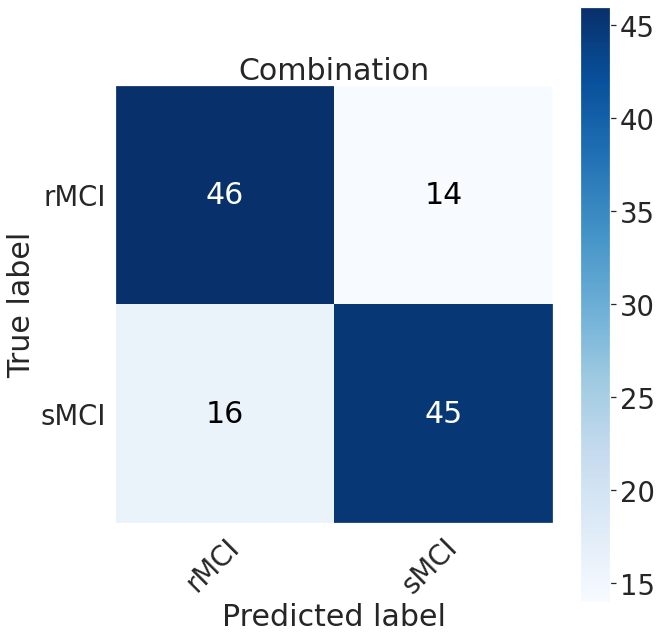

              precision    recall  f1-score   support

        rMCI       0.74      0.77      0.75        60
        sMCI       0.76      0.74      0.75        61

    accuracy                           0.75       121
   macro avg       0.75      0.75      0.75       121
weighted avg       0.75      0.75      0.75       121

Permutation Importance based on Testset



Weight,Feature
0.2744 ± 0.0764,Current_Age
0.2099 ± 0.0698,AGE_mean
0.0579 ± 0.0701,dev_bl_Hipp
0.0413 ± 0.0431,random_slope_Vent
0.0314 ± 0.0648,dev_last_Vent
0.0116 ± 0.0081,random_slope_Hipp
0.0116 ± 0.0399,dev_last_Hipp
0.0017 ± 0.0219,dev_bl_Vent
0.0017 ± 0.0066,Group_Hipp
0.0000 ± 0.0296,Group_Vent


In [292]:
roi1 = 'Hippocampus'
roi2 = 'Ventricles'
rm_cols = ['AGE_mean','Max_AGE', 'DX2', 'DX2N', 'SEX']

##############Train Set ##############

dic1 =  train_lin_feat
dic2 =train_lin_feat

X,y =combine_ROIs(dic1, dic2, roi1,roi2,rm_cols,'DX2')
dic_r = {'sMCI':'sMCI', 'cAD':'rMCI'}
y = y.map(dic_r)


############# Test set ##############
dic1_test =  test_lin_feat
dic2_test =test_lin_feat

X_test,y_test = combine_ROIs(dic1_test, dic2_test, roi1,roi2,rm_cols,'DX2')
y_test = y_test.map(dic_r)
################### Cross validation ###########################
modelsLL= []
nb_splits = min([y.value_counts().values[i] for i in range(len(y.value_counts()))])
print('number of split', nb_splits)


print('\n ================== Logistic Regession =====================\n')

lr_std = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, solver='lbfgs', max_iter=500))
lr_minmax = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42,  solver='lbfgs', max_iter=500))
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': np.linspace(0.1, 10, 10)
}

print('Standard scaler \n')
lr_model_std = run_gridsearch(lr_std, param_grid,X,y, cv=nb_splits, reevaluate=True)
lr_model_minmax = run_gridsearch(lr_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)
lr_model = lr_model_std
modelsLL.append(lr_model)
print(f'Logistic Regression score: {lr_model.score(X_test,y_test)}')
miss_lr, test_detail_lr, feature_test_lr=confusion_matrix_permutation(lr_model, X, X_test, y, y_test,roi, label = 'DX2')


print('\n ================== SVM =====================\n')

svm_std = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))
svm_minmax = make_pipeline(MinMaxScaler(), SVC(random_state=42, probability=True))

param_grid = {
    'svc__C':  np.linspace(0.1, 10, 10), 
    'svc__gamma': ['scale','auto'],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']}

svm_model_std = run_gridsearch(svm_std, param_grid,X , y ,cv=nb_splits, reevaluate=True)
svm_model_minmax = run_gridsearch(svm_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)

svm_model = svm_model_minmax
modelsLL.append(svm_model)
print(f'SVM score: {svm_model.score(X_test,y_test)}')
miss_svm, test_detail_svm, feature_test_svm = confusion_matrix_permutation(svm_model, X, X_test, y, y_test, roi, label = 'DX2')



print('\n ================== Ensemble Classifier =====================\n')

print('Models: ',modelsLL)
eclf_LL = evaluate_ensemble(modelsLL, X,y ,nb_splits, voting='soft')
save_model(eclf_LL, 'ensemble_model_NLHip_NLVent_AD')

print(f'Ensemble score on test set: {eclf_LL.fit(X,y).score(X_test,y_test)}')
miss_eclf, test_detail_eclf, feature_test_eclf_c2 = confusion_matrix_permutation(eclf_LL, X, X_test, y, y_test,'Combination', label = 'DX2')


**Combination of features extracted from quadratic linear mixed effects model for Hippocampi and Ventricles.**


 Same order for features is True
(431, 9) (431, 9)
Same order for labels is True

 Same order for features is True
(121, 9) (121, 9)
Same order for labels is True
number of split 210

 ================== Logistic Regession =====================

Standard scaler 

(431, 15) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 748 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    6.9s finished


Best accuracy: 0.7857142857142857
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7857142857142857
Mean train accuracy: 0.7974110520839494
(431, 15) (431,)
Fitting 210 folds for each of 10 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    7.6s finished


Best accuracy: 0.7603174603174603
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7603174603174603
Mean train accuracy: 0.7698020567179447
Logistic Regression score: 0.743801652892562
training score :  0.744
[('rMCI', 60), ('sMCI', 61)]


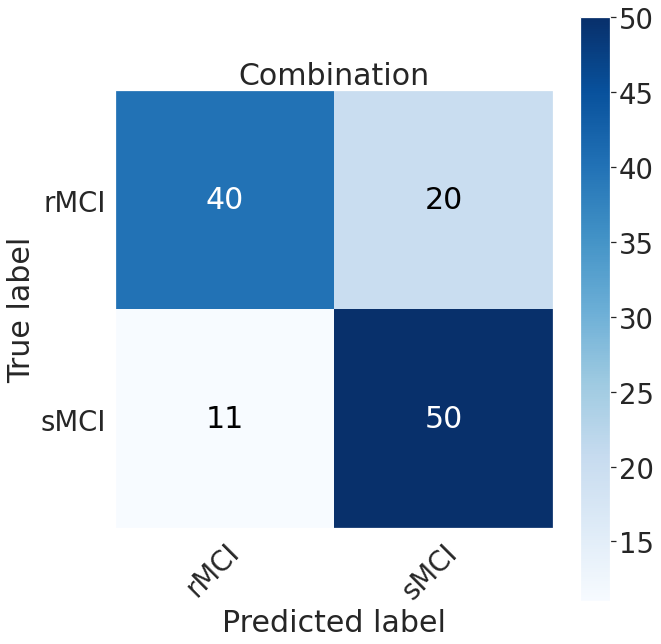

              precision    recall  f1-score   support

        rMCI       0.78      0.67      0.72        60
        sMCI       0.71      0.82      0.76        61

    accuracy                           0.74       121
   macro avg       0.75      0.74      0.74       121
weighted avg       0.75      0.74      0.74       121

Permutation Importance based on Testset



Weight,Feature
0.2397 ± 0.0782,Current_Age
0.2298 ± 0.0749,AGE_mean
0.1174 ± 0.0337,dev_last_Hipp
0.0017 ± 0.0162,Group_Vent
0.0017 ± 0.0193,slop_Hipp
0 ± 0.0000,random_slope_Hipp
-0.0000 ± 0.0105,dev_bl_Vent
-0.0000 ± 0.0105,AGE2_Hipp
-0.0017 ± 0.0303,dev_last_Vent
-0.0033 ± 0.0132,random_slope_Vent



 ================== SVM =====================

(431, 15) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:   58.8s finished


Best accuracy: 0.7507936507936508
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.7507936507936508
Mean train accuracy: 0.8746214325653577
(431, 15) (431,)
Fitting 210 folds for each of 60 candidates, totalling 12600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done 12600 out of 12600 | elapsed:  1.2min finished


Best accuracy: 0.780952380952381
Re-evaluating using `evaluate_model` and leave-one-out
Mean test accuracy: 0.780952380952381
Mean train accuracy: 0.8629315648007236
SVM score: 0.7520661157024794
training score :  0.752
[('rMCI', 60), ('sMCI', 61)]


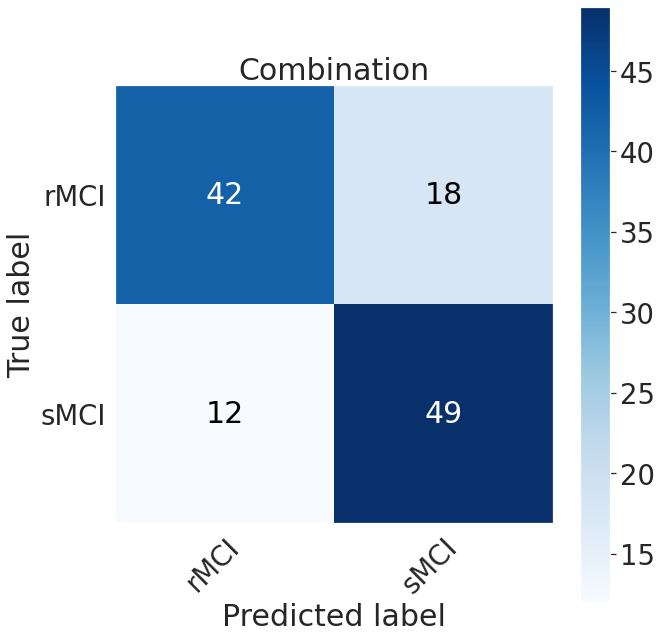

              precision    recall  f1-score   support

        rMCI       0.78      0.70      0.74        60
        sMCI       0.73      0.80      0.77        61

    accuracy                           0.75       121
   macro avg       0.75      0.75      0.75       121
weighted avg       0.75      0.75      0.75       121

Permutation Importance based on Testset



Weight,Feature
0.2562 ± 0.0761,Current_Age
0.2446 ± 0.0578,AGE_mean
0.1041 ± 0.0463,dev_bl_Hipp
0.0926 ± 0.0516,dev_last_Vent
0.0694 ± 0.0324,dev_bl_Vent
0.0628 ± 0.0486,dev_last_Hipp
0.0215 ± 0.0224,slop_Hipp
0.0215 ± 0.0247,AGE2_Vent
0.0198 ± 0.0288,Group_Hipp
0.0132 ± 0.0508,Group_Vent



 ================== Ensemble Classifier =====================

Models:  [Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=4.5, max_iter=500, random_state=42))]), Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc',
                 SVC(C=5.6, kernel='poly', probability=True, random_state=42))])]
Mean test accuracy: 0.7888888888888889
Mean train accuracy: 0.8273849203755747
Ensemble score on test set: 0.7768595041322314
training score :  0.777
[('rMCI', 60), ('sMCI', 61)]


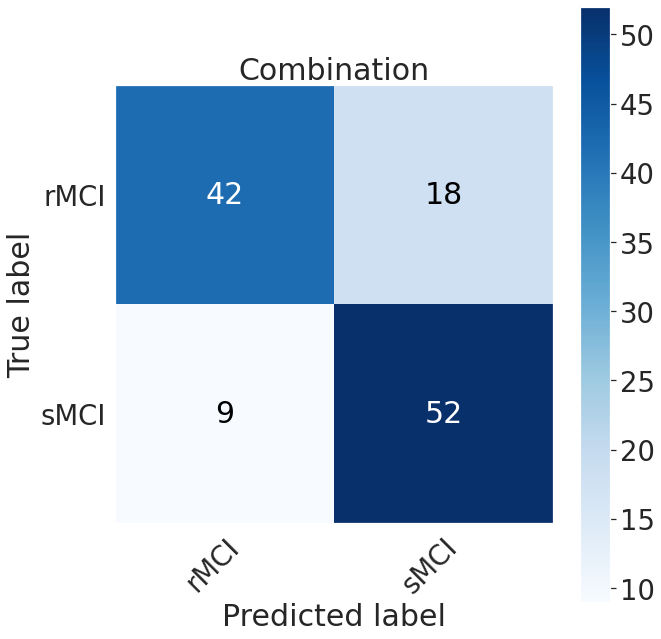

              precision    recall  f1-score   support

        rMCI       0.82      0.70      0.76        60
        sMCI       0.74      0.85      0.79        61

    accuracy                           0.78       121
   macro avg       0.78      0.78      0.78       121
weighted avg       0.78      0.78      0.78       121

Permutation Importance based on Testset



Weight,Feature
0.2760 ± 0.0706,Current_Age
0.2645 ± 0.0644,AGE_mean
0.0975 ± 0.0527,dev_last_Vent
0.0711 ± 0.0426,dev_last_Hipp
0.0463 ± 0.0386,dev_bl_Hipp
0.0413 ± 0.0277,dev_bl_Vent
0.0264 ± 0.0264,Group_Vent
0.0165 ± 0.0314,AGE2_Vent
0.0066 ± 0.0303,SEX
0.0050 ± 0.0132,slop_Hipp


In [295]:
roi1 = 'Hippocampus'
roi2 = 'Ventricles'
rm_cols = ['AGE_mean','Max_AGE', 'DX2', 'DX2N', 'SEX']

##############Train Set ##############

dic1 =  train_Nlin_feat
dic2 =train_Nlin_feat

X,y =combine_ROIs(dic1, dic2, roi1,roi2,rm_cols,'DX2')
dic_r = {'sMCI':'sMCI', 'cAD':'rMCI'}
y = y.map(dic_r)


############# Test set ##############
dic1_test =  test_Nlin_feat
dic2_test =test_Nlin_feat

X_test,y_test = combine_ROIs(dic1_test, dic2_test, roi1,roi2,rm_cols,'DX2')
y_test = y_test.map(dic_r)
################### Cross validation ###########################
modelsNN= []
nb_splits = min([y.value_counts().values[i] for i in range(len(y.value_counts()))])
print('number of split', nb_splits)


print('\n ================== Logistic Regession =====================\n')

lr_std = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, solver='lbfgs', max_iter=500))
lr_minmax = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42,  solver='lbfgs', max_iter=500))
param_grid = {
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': np.linspace(0.1, 10, 10)
}

print('Standard scaler \n')
lr_model_std = run_gridsearch(lr_std, param_grid,X,y, cv=nb_splits, reevaluate=True)
lr_model_minmax = run_gridsearch(lr_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)
lr_model = lr_model_std
save_model(lr_model, 'logreg_model_Lvent')
modelsNN.append(lr_model)
print(f'Logistic Regression score: {lr_model.score(X_test,y_test)}')
miss_lr, test_detail_lr, feature_test_lr=confusion_matrix_permutation(lr_model, X, X_test, y, y_test,'Combination', label = 'DX2')


print('\n ================== SVM =====================\n')

svm_std = make_pipeline(StandardScaler(), SVC(random_state=42, probability=True))
svm_minmax = make_pipeline(MinMaxScaler(), SVC(random_state=42, probability=True))

param_grid = {
    'svc__C':  np.linspace(0.1, 10, 10), 
    'svc__gamma': ['scale','auto'],
    'svc__kernel': ['rbf', 'poly', 'sigmoid']}

svm_model_std = run_gridsearch(svm_std, param_grid,X , y ,cv=nb_splits, reevaluate=True)
svm_model_minmax = run_gridsearch(svm_minmax, param_grid,X,y, cv=nb_splits, reevaluate=True)

svm_model = svm_model_minmax
save_model(svm_model, 'svm_model_Lvent')
modelsNN.append(svm_model)
print(f'SVM score: {svm_model.score(X_test,y_test)}')
miss_svm, test_detail_svm, feature_test_svm = confusion_matrix_permutation(svm_model, X, X_test, y, y_test, 'Combination', label = 'DX2')



print('\n ================== Ensemble Classifier =====================\n')

print('Models: ',modelsNN)
eclf_NN = evaluate_ensemble(modelsNN, X,y ,nb_splits, voting='soft')
save_model(eclf_NN, 'ensemble_model_NLHip_NLVent_AD')

print(f'Ensemble score on test set: {eclf_NN.fit(X,y).score(X_test,y_test)}')
miss_eclf, test_detail_eclf, feature_test_eclf_c2 = confusion_matrix_permutation(eclf_NN, X, X_test, y, y_test,'Combination', label = 'DX2')
